In [1]:
import pandas as pd
%run utils.ipynb

In [2]:
dos_df, fuzzy_df, attack_free_df=load_datasets_using_pd()

# Exploratory Data Analysis

## Common Methods

In [3]:
def show_shape_info_of_data(data):
    print("Data Shape")
    print("*" * 40)
    print(f"Rows: {data.shape[0]}, Columns: {data.shape[1]}")
    print("\nInfo")
    print("*" * 40)
    info_dict={
        "Column": data.columns,
        "Data Type": data.dtypes,
        "Null Count": data.isnull().sum(),
        "Unique Count":data.nunique()}
    info_df = pd.DataFrame(info_dict)
    print(info_df.to_string(index=False))


In [50]:
def concatenate_columns(cols, new_column_name,data):
    """
    Merges multiple columns into a single column by concatenating their values.

    Parameters
    ----------
    cols : list[str]
        List of column names to be merged.
    new_column_name : str
        Name of the new column that will store the merged values.
    data : pd.DataFrame
        The DataFrame containing the columns to be merged.

    Returns
    -------
    pd.DataFrame
        Updated DataFrame with the new merged column.
    """
    data[new_column_name] = ""
    for col in cols:
        data[new_column_name] += data[col]
    return data


In [5]:
def convert_timestamp_to_datetime(col_to_be_added_name,existing_col_name, data):
    """
    Convert timestamp column to a datetime column .

    Parameters
    ----------
    col_to_be_added_name : str
        Name of the new column to store the converted datetime values.
    existing_col_name : _type_
        Name of existing column containing timestamps in seconds
    data : pd.DataFrame
        DataFrame containing the existing column.

    Returns
    -------
    pd.DataFrame
        DataFrame with the new datetime column added
    """

    data[col_to_be_added_name] = pd.to_datetime(data[existing_col_name], unit='s')
    return data

In [30]:
def extract_datetime_components(existing_col_name,data):
    """
    Extracts year, month, day, and hour from a datetime column and adds them as new columns.

    Parameters
    ----------
    existing_col_name : str
        The name of the column containing datetime values.
    data : pd.DataFrame
        The DataFrame containing the datetime column.

    Returns
    -------
    pd.DataFrame
        DataFrame with added columns: 'year', 'month', 'day', and 'hour'.
    """
    data['year'] = data[existing_col_name].dt.year
    data['month'] = data[existing_col_name].dt.month
    data['day'] = data[existing_col_name].dt.day
    data['hour']=data[existing_col_name].dt.hour

    return data


In [28]:
def print_start_end_timestamps(data,column_name):
    """
    Prints the start and end timestamps from a specified column in a DataFrame.

    Parameters
    ----------
    data : pd.DataFrame
        The DataFrame containing the timestamp column.
    column_name : str
        The name of the column containing timestamp values.

    Returns
    -------
    None
        This function prints the start and end timestamps but does not return anything.
    """
    print("Start Time: ",data[column_name].iloc[0])
    print("End Time: ",data[column_name].iloc[-1])

In [38]:
def convert_hex_to_int(value):
    """
    Converts a hexadecimal string to an integer. If the value is already an integer, it is returned as is.

    Parameters
    ----------
    value : str | int
        The value to convert. If a string, it should represent a valid hexadecimal number.

    Returns
    -------
    int
        The converted integer value.

    Raises
    ------
    ValueError
        If the string is not a valid hexadecimal number.
    """
    if isinstance(value, str):
        try:
            return int(value,16)
        except ValueError:
            raise ValueError(f"Invalid hexadecimal value: {value}")
    return value  

In [34]:
def print_unique_datetime_components (data):
    """
    Prints the unique values of the 'day', 'month', 'year', and 'hour' columns in a DataFrame.

    Parameters
    ----------
    data : pd.DataFrame
        The DataFrame containing 'day', 'month', 'year', and 'hour' columns.

    Returns
    -------
    None
        This function prints unique values but does not return anything.
    """
    for col in ['day','month','year','hour']:
        print(col,data[col].unique())

## DoS

In [10]:
show_shape_info_of_data(dos_df)

Data Shape
****************************************
Rows: 3665770, Columns: 12

Info
****************************************
      Column Data Type  Null Count  Unique Count
   timestamp   float64           0       3665770
      can_id    object           0            27
         dlc     int64           0             2
      byte_0    object           0           108
      byte_1    object           0            71
      byte_2    object       31188            75
      byte_3    object       31188            26
      byte_4    object       31188           190
      byte_5    object       31188           256
      byte_6    object       31188            75
      byte_7    object       31188           256
updated_flag    object           0             2


In [11]:
dos_df=convert_timestamp_to_datetime("datetime","timestamp", dos_df)


In [ ]:
print_start_end_timestamps(dos_df,"datetime")


Start Time:  2016-11-03 18:39:36.389636040
End Time:  2016-11-03 19:26:49.058943987


In [31]:
dos_df=extract_datetime_components("datetime",dos_df)

In [35]:
print_unique_datetime_components (dos_df)


day [3]
month [11]
year [2016]
hour [18 19]


In [39]:
col="can_id"
dos_df["updated_can_id"] = dos_df[col].apply(convert_hex_to_int)

In [43]:
# dos_df["updated_can_id"].value_counts()

In [45]:
col="dlc"
dos_df[col].value_counts()

dlc
8    3634582
2      31188
Name: count, dtype: int64

In [47]:
#T or R, T represents injected message while R represents normal message
col="updated_flag"
dos_df[col].value_counts()

updated_flag
R    3078249
T     587521
Name: count, dtype: int64

In [51]:
bytes_col_list=[col for col in dos_df.columns if col.startswith("byte")]
dos_df=concatenate_columns(bytes_col_list,"merged_bytes",dos_df)

In [54]:
col="merged_bytes"
dos_df[col].nunique()

66913

### Insights about DoS Attack

- Data was collected in November 3, 2016 and between 18-19 PM.
- CAN ID
    - Most rows are with id 0. It can be DoS attack.
    - Data with 160 and 161 are smallest number after O. When we think about DoS attack logic, they can also be considered as attack. 
    - **But the problem is 160 and 161 id exist so rare.**
- DLC
    - It shows length of data field in bytes.
    - It is either 2 or 8.
- Byte0 ... Byte7
    - it shows data field in eight columns in bytes.
    - First two bytes have no null count. Last 5 byte have more than 30k null count. 
    - When you merge 8 columns into one columns, you can seee 66K unique data field.
- Flag
    - It can be T or R
        - T-> injected message
        - R-> normal message
    - Normal message is nearly five times bigger than injected message.


## Fuzzy

In [56]:
show_shape_info_of_data(fuzzy_df)

Data Shape
****************************************
Rows: 3838859, Columns: 12

Info
****************************************
      Column Data Type  Null Count  Unique Count
   timestamp   float64           0       3838859
      can_id    object           0          2048
         dlc     int64           0             4
      byte_0    object           0           256
      byte_1    object           0           256
      byte_2    object       34382           256
      byte_3    object       34382           256
      byte_4    object       34382           256
      byte_5    object       87833           256
      byte_6    object       87836           256
      byte_7    object       87836           256
updated_flag    object           0             2


In [57]:
fuzzy_df=convert_timestamp_to_datetime("datetime","timestamp", fuzzy_df)


In [58]:
print_start_end_timestamps(fuzzy_df,"datetime")

Start Time:  2016-11-03 17:55:21.905735970
End Time:  2016-11-03 19:26:49.058943987


In [59]:
fuzzy_df=extract_datetime_components("datetime",fuzzy_df)

In [60]:
print_unique_datetime_components (fuzzy_df)

day [3]
month [11]
year [2016]
hour [17 18 19]


In [62]:
col="can_id"
fuzzy_df["updated_can_id"] = fuzzy_df[col].apply(convert_hex_to_int)

In [65]:
col="updated_can_id"
fuzzy_df[col].value_counts()[:30]

updated_can_id
790     182121
2       180011
399     179802
704     179637
1087    179538
848     178687
339     178188
304     178149
608     178049
880     177691
672     177174
305     176116
809     175761
1088    175479
320     175211
1349    173707
1072     92917
1201     90109
497      89766
1264     88946
688      53477
1520     34617
160      18266
161      17930
1680     17880
1440      1988
1442      1932
1706       458
1999       446
802        294
Name: count, dtype: int64

In [67]:
col="dlc"
fuzzy_df[col].value_counts()

dlc
8    3751023
5      53451
2      34382
6          3
Name: count, dtype: int64

In [68]:
fuzzy_df=concatenate_columns(bytes_col_list,"merged_bytes",fuzzy_df)

In [69]:
col="merged_bytes"
fuzzy_df[col].nunique()

560012

In [70]:
fuzzy_df["updated_flag"].value_counts()

updated_flag
R    3347012
T     491847
Name: count, dtype: int64

### Insights about Fuzzy Attack
- In attack free data, dlc can be 2 or 8. In fuzzy attack it can be 2,5,6,and 8. 5 and 6 can be quickly find as malicious.
- When we merge bytes columns, fuzzy attack have 560k unique data. Four unique dlc may create this huge unique data number
- 

- Data was collected in November 3, 2016 and between 17-19 PM.
- **End time of Dos and Fuzzy Attack is same**
        - dos df
    
            Start Time:  2016-11-03 18:39:36.389636040
            End Time:  2016-11-03 19:26:49.058943987
    
        - fuzzy df
    
            Start Time:  2016-11-03 17:55:21.905735970
            End Time:  2016-11-03 19:26:49.058943987

- CAN ID
    - There are unique 2048 values.
    - Most used id is 790.

- DLC
    - It shows length of data field in bytes.
    - It can be 2,5,6,8.
    - We should delete rows with dlc is 2,5,6. Because, they are rare.
            dlc
        - 8  -  3751023
        - 5   -   53451
        - 2    -  34382
        - 6   -       3

- Byte0 ... Byte7
    - it shows data field in eight columns in bytes.
    - First two bytes have no null count. Byte_2-Byte_4 have 35k null count, Byte_5-Byte_7 have 88k null count.
    - When you merge 8 columns into one columns, you can seee 560K unique data field.
- Flag
    - It can be T or R
        - T-> injected message
        - R-> normal message
    - R   - 3.347.012
    - T   -  491.847

## Attack Free

In [71]:
show_shape_info_of_data(attack_free_df)

Data Shape
****************************************
Rows: 988871, Columns: 12

Info
****************************************
    Column Data Type  Null Count  Unique Count
 timestamp   float64           0        988871
    can_id    object           0            27
frame_type     int64           0             1
       dlc     int64           0             3
    byte_0    object           0           256
    byte_1    object           0           256
    byte_2    object       10129           256
    byte_3    object       10129           256
    byte_4    object       10129           256
    byte_5    object       60735           256
    byte_6    object       60735           227
    byte_7    object       60735           256


In [72]:
col="timestamp"
attack_free_df=convert_timestamp_to_datetime("datetime","timestamp", attack_free_df)


In [73]:
print_start_end_timestamps(attack_free_df,"datetime")

Start Time:  2016-11-14 11:03:54.850202084
End Time:  2016-11-14 11:12:21.286772966


In [74]:
attack_free_df=extract_datetime_components("datetime",attack_free_df)

In [75]:
print_unique_datetime_components(attack_free_df)


day [14]
month [11]
year [2016]
hour [11]


In [76]:
col="can_id"
attack_free_df["updated_can_id"] = attack_free_df[col].apply(convert_hex_to_int)


In [77]:
attack_free_df["updated_can_id"].value_counts()

updated_can_id
704     50689
399     50687
608     50687
672     50687
790     50687
809     50686
1349    50686
848     50661
305     50647
304     50647
2       50647
339     50647
320     50647
880     50641
1087    50641
1088    50641
688     50606
1072    25324
1201    25324
497     25324
1264    25322
1520    10129
161      5068
160      5068
1680     5064
1440      507
1442      507
Name: count, dtype: int64

In [78]:
attack_free_can_id_set=set(attack_free_df["updated_can_id"].unique())
dos_can_id_set=set(dos_df["updated_can_id"].unique())

print("only in dos",dos_can_id_set-attack_free_can_id_set)
print("only in attack free",attack_free_can_id_set-dos_can_id_set)

only in dos {np.int64(0)}
only in attack free {np.int64(688)}


In [79]:
col="frame_type"
attack_free_df[col].unique()

array([0])

In [81]:
col="dlc"
attack_free_df[col].value_counts()

dlc
8    928136
5     50606
2     10129
Name: count, dtype: int64

In [82]:
bytes_col_list=[col for col in attack_free_df.columns if col.startswith("byte")]
attack_free_df=concatenate_columns(bytes_col_list,"merged_bytes",attack_free_df)

In [84]:
col="merged_bytes"
attack_free_df[col].nunique()

275180

### Insights about Attack Free
- Data was collected in November 3, 2016 and between 11:03-11:12 PM.
- CAN ID
    - 704 is most used one as an id.
    - When we look at count_values(), we can see number of count values are in  cluster form.
- Frame Type
    - I named 000 as frame_type but not sure whether it is frame_type or not because it can be rtr that show it is standart can frame or extended can frame.
    - Assume it is really frame type. It is value only is 000 and data frame not a remote frame.
- DLC
    - It shows length of data field in bytes.
    - It is either 2,5,8.
    - We should delete 2 and 5.
        - 8  -  928136
        - 5   -  50606
        - 2   -  10129

- Byte0 ... Byte7
    - it shows data field in eight columns in bytes.
    - First two bytes have no null count. Last 3 bytes have more than 60k null count. 
    - When you merge 8 columns into one columns, you can seee 275K unique data field.


    



## General Insights

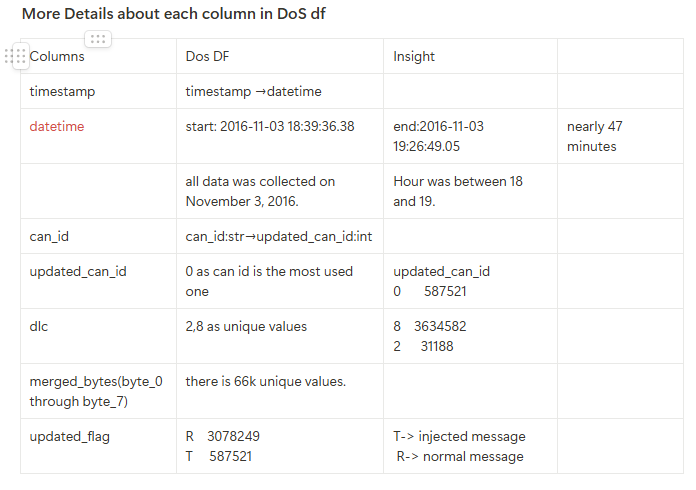

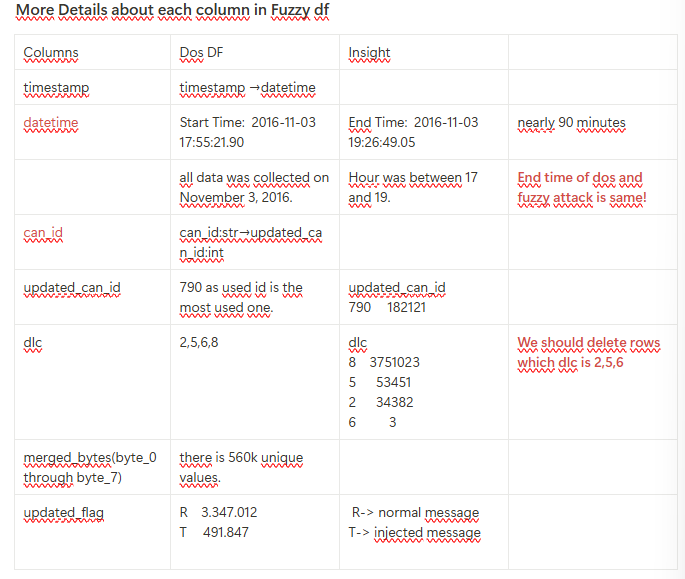

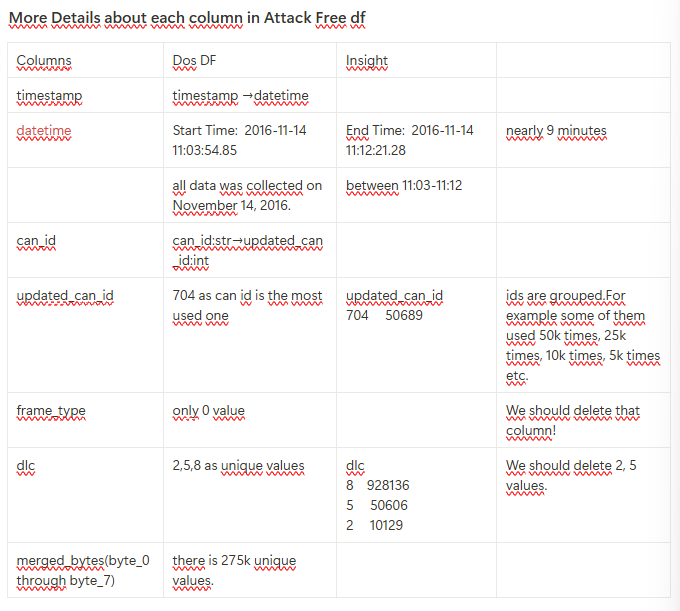